# Throwing Axes

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [3]:
# import functions from modsim

from modsim import *

My favorite event at Lumberjack Competitions is axe throwing.  The axes used for this event typically weigh 1.5 to 2 kg, with handles roughly 0.7 m long.  They are thrown overhead at a target typically 6 m away and 1.5 m off the ground.  Normally, the axe makes one full rotation in the air to hit the target blade first, with the handle close to vertical.

![Diagram of throwing axe](https://github.com/AllenDowney/ModSim/raw/main/figs/throwingaxe1.png)

Here's a version of `make_system` that sets the initial conditions.

The state variables are x, y, theta, vx, vy, omega, where theta is the orientation (angle) of the axe in radians and omega is the angular velocity in radians per second.

I chose initial conditions based on videos of axe throwing.

In [4]:
g = 9.8       # m/s**2,
mass = 1.5    # kg,
length = 0.7  # m

In [5]:
x = 0      # m
y = 2      # m
vx = 8     # m / s
vy = 4     # m / s
theta = 2            # rad
omega = -7           # rad / s

In [6]:
init = State(x=x, y=y, 
             vx=vx, vy=vy, 
             theta=theta, omega=omega)

In [7]:
system = System(init=init, t_end=1)

As a simple starting place, I ignore drag, so `vx` and `omega` are constant, and `ay` is just `-g`.

In [8]:
def slope_func(t, state, system):
    x, y, vx, vy, theta, omega = state

    ax = 0
    ay = -g
    alpha = 0

    return vx, vy, ax, ay, omega, alpha

As always, let's test the slope function with the initial conditions.

In [9]:
slope_func(0, system.init, system)

(8, 4, 0, -9.8, -7, 0)

And then run the simulation.

In [10]:
results, details = run_solve_ivp(system, slope_func)
details

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 32
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f12e59bcc70>
   status: 0
  success: True
 t_events: None
 y_events: None

In [11]:
results.tail()

,x,y,vx,vy,theta,omega
0.96,7.68,1.32416,8.0,-5.408,-4.72,-7.0
0.97,7.76,1.26959,8.0,-5.506,-4.79,-7.0
0.98,7.84,1.21404,8.0,-5.604,-4.86,-7.0
0.99,7.92,1.15751,8.0,-5.702,-4.93,-7.0
1.00,8.00,1.10000,8.0,-5.800,-5.00,-7.0


### Visualizing the results

The simplest way to visualize the results is to plot the state variables as a function of time.

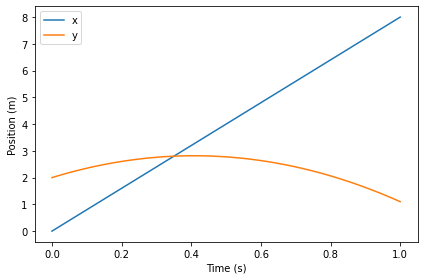

In [12]:
def plot_position(results):
    results.x.plot(label='x')
    results.y.plot(label='y')

    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)

We can plot the velocities the same way.

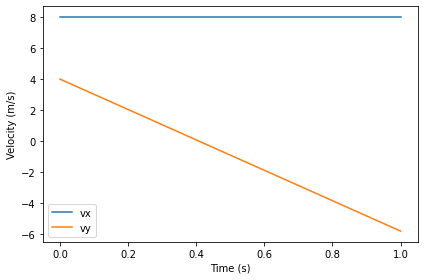

In [13]:
def plot_velocity(results):
    results.vx.plot(label='vx')
    results.vy.plot(label='vy')

    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

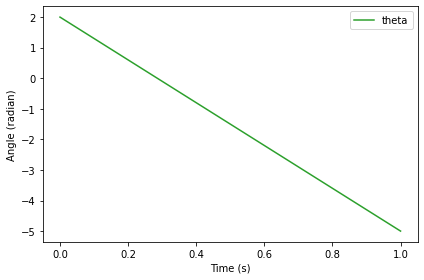

In [14]:
results.theta.plot(label='theta', color='C2')

decorate(xlabel='Time (s)',
         ylabel='Angle (radian)')

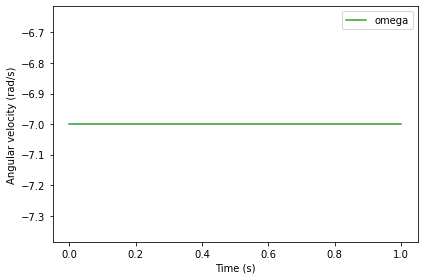

In [15]:
results.omega.plot(label='omega', color='C2')

decorate(xlabel='Time (s)',
         ylabel='Angular velocity (rad/s)')

Another way to visualize the results is to plot y versus x.  The result is the trajectory through the plane of motion.

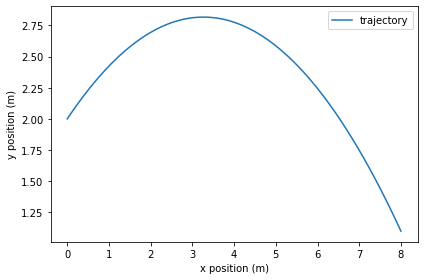

In [16]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajectory')
    
    decorate(xlabel='x position (m)',
             ylabel='y position (m)')
    
plot_trajectory(results)

## Animation

Animating this system is a little more complicated, if we want to show the shape and orientation of the axe.

It is useful to construct a frame with $\hat{r}$ along the handle of the axe and $\hat{\theta}$ perpendicular.

In [17]:
def make_frame(theta):
    x, y = pol2cart(theta, 1)
    rhat = Vector(x, y)
    that = vector_perp(rhat)
    return rhat, that

In [25]:
theta = 1
rhat, that = make_frame(theta)

In [26]:
rhat

x    0.540302
y    0.841471
dtype: float64

In [27]:
that

x   -0.841471
y    0.540302
dtype: float64

In [28]:
np.dot(rhat, that)

0.0

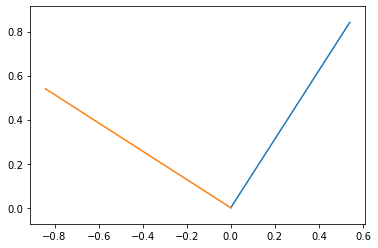

In [29]:
O = Vector(0, 0)
plot_segment(O, rhat)
plot_segment(O, that)
plt.axis('equal');

Now we're ready to animate the results.  The following figure shows the frame and the labeled points A, B, C, and D.

![Diagram of the axe with reference frame](https://github.com/AllenDowney/ModSim/raw/main/figs//throwingaxe2.png)

In [60]:
l1 = 0.6
l2 = 0.1

def draw_func(t, state):   
    x, y, vx, vy, theta, omega = state
    P = Vector(x, y)
    rhat, that = make_frame(theta)
    
    # plot the handle
    A = P - l1 * rhat
    B = P + l2 * rhat
    plot_segment(A, B, color='red')

    # plot the axe head
    C = B + l2 * that
    D = B - l2 * that
    plot_segment(C, D, color='black', linewidth=10)

    # plot the COG
    plt.plot(x, y, 'bo')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=[-0.3, 8.2],
             ylim=[0, 5]
            )

During the animation, the parts of the axe seem to slide around relative to each other.  I think that's because the lines and circles get rounded off to the nearest pixel.

Here's the final state of the axe at the point of impact (assuming the target is 8 m away).

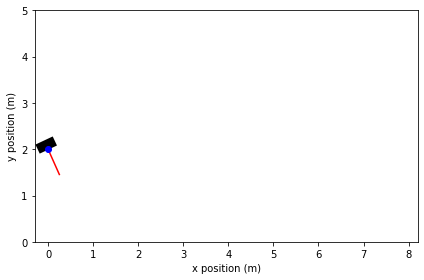

In [61]:
draw_func(0, system.init)

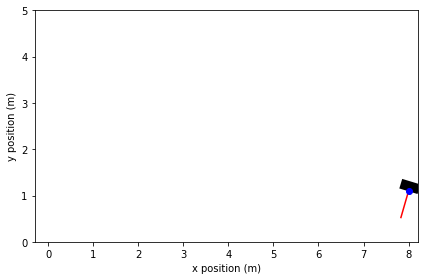

In [62]:
animate(results, draw_func)

## Exercises

**Exercise:**  Find the starting conditions that make the final height of the COG as close as possible to 1.5 m.  Ideally, the final angle should be a little past vertical.